<h1 style='text-align: center'>Explore CLIP Text Encoder</h1>

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

from dataset import IUXrayDataset
from models.clip_encoder import CLIPEncoder

/home/li.you3/.conda/envs/vision/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load the dataset

data_dir = "../data/IU-XRay"

train_dataset = IUXrayDataset(data_dir, image_size=224, is_train=True)
val_dataset = IUXrayDataset(data_dir, image_size=224, is_train=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

2025-04-19 00:54:46,747 - INFO - Loaded 7470 samples
2025-04-19 00:54:49,313 - INFO - Loaded 7470 samples


Train dataset size: 6723
Validation dataset size: 747


In [4]:
model_name = "microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224"

text_encoder = CLIPEncoder(
    model_name=model_name,
    max_length=128,
    diffusion_dim=512
).to(device)

2025-04-19 00:54:49,613 - INFO - Loaded hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224 model config.


2025-04-19 00:54:53,140 - INFO - Loading pretrained hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224 weights (/home/li.you3/.cache/huggingface/hub/models--microsoft--BiomedCLIP-PubMedBERT_256-vit_base_patch16_224/snapshots/9f341de24bfb00180f1b847274256e9b65a3a32e/open_clip_pytorch_model.bin).


In [5]:
test_medical_terms = [
    "Normal heart size",
    "Normal pulmonary vascularity",
    "No pleural effusion",
    "Clear lungs",
    "Calcified granuloma",
    "No pneumothorax"
]


def encode_and_visualize(encoder, terms):
    """Encode terms and visualize their embeddings"""
    with torch.no_grad():
        raw_embeddings, projected_embeddings = encoder.forward(terms)
        embeddings = raw_embeddings.mean(dim=1).cpu().numpy()

    pca = PCA(n_components=2)
    reduced_embeds = pca.fit_transform(embeddings)

    similarity = cosine_similarity(embeddings)

    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_embeds[:, 0], reduced_embeds[:, 1], s=100)
    for i, term in enumerate(terms):
        plt.annotate(term, (reduced_embeds[i, 0], reduced_embeds[i, 1]), 
                     fontsize=9, ha='right')
    plt.title(f"2D PCA")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(alpha=0.3)
    plt.show()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=[t[:15] + "..." if len(t) > 15 else t for t in terms],
                yticklabels=[t[:15] + "..." if len(t) > 15 else t for t in terms])
    plt.title(f"Cosine Similarity")
    plt.tight_layout()
    plt.show()

Initial Medical Term Understanding:


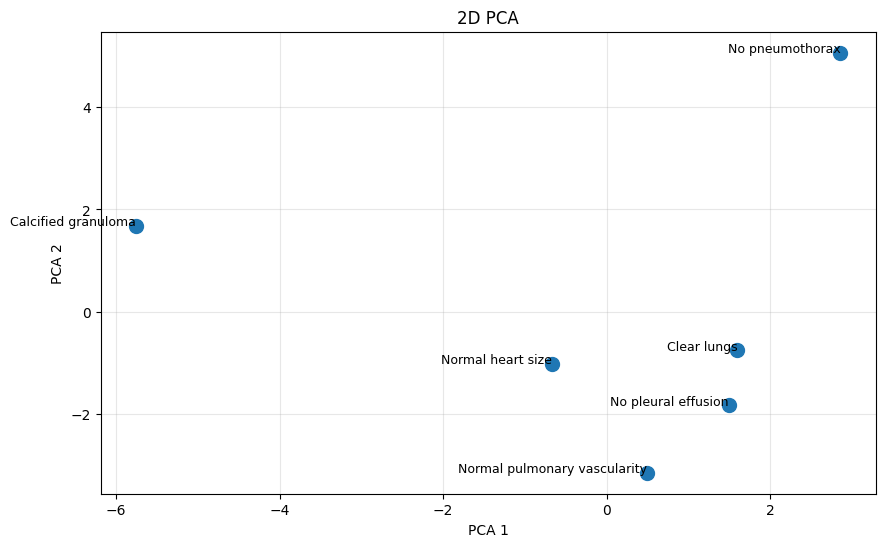

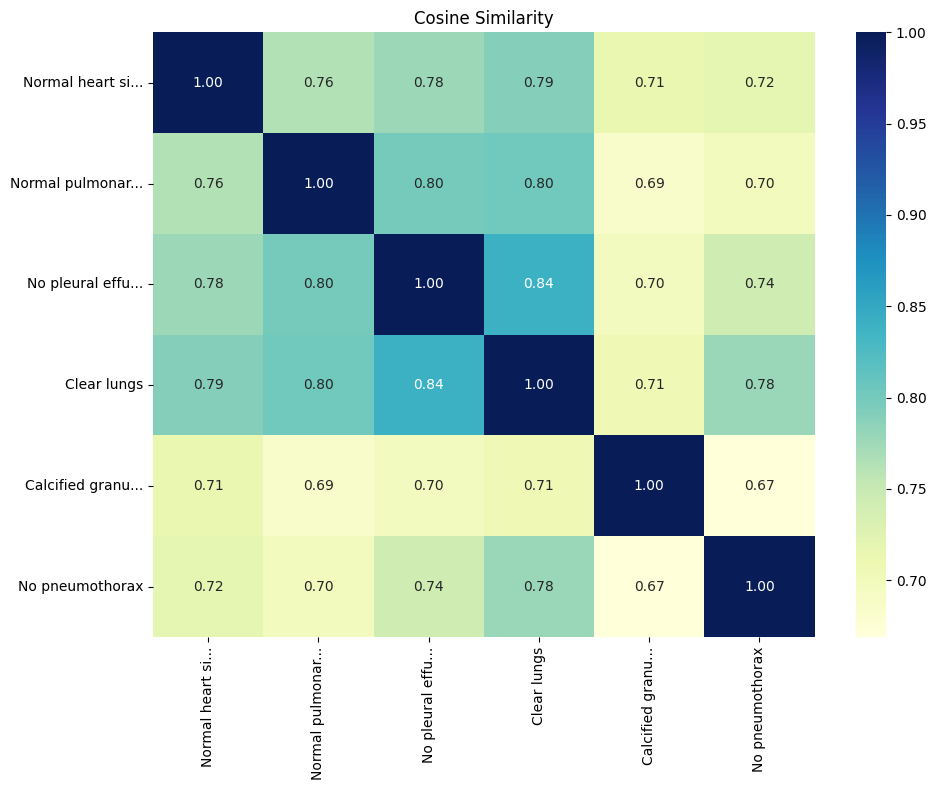

In [6]:
print("Initial Medical Term Understanding:")
encode_and_visualize(text_encoder, test_medical_terms)